# Decomposing Shared Parameter Gradients in RNNs

## 1. Introduction

### 1.1 Motivation
In one of my first introductions to deep learning (it was from a different class, sorry Alf!), I heard about the problem of vanishing and exploding gradients. Now, this can be a problem with any deep neural network, but it is particularly bad with RNNs due to their recursive structure.

For instance if $\tilde y_t = f(f(f(...f(h_0, x_0), x_{t-2}), x_{t-1}), x_t)$, then if f is an expanding or contracting map, \frac{\tilde y_t}{dx_0} is an exponentially exploding or vanishing gradient (this is just a heuristic, we'll explain the exact formulation soon).

Since prevailing methods of optimization are gradient based, this obviously makes optimization hard because you would expect that these exponentially large or exponentially small gradients would prevent these models from converging (moving too fast, or moving too slowly).

### 1.2 Related Work

Lots of work was done in the years (2012-2016) on the optimization of RNNs. One paper that particularly stands out in RNN optimization is "On the difficulty of training Recurrent Neural Networks" (Pascanu et. al, 2012), which introduced a clipping strategy to prevent gradients from exploding, and a regularizer to prevent gradients from being too small.

Another paper addressing this problem is "Unitary Evolution Recurrent Neural Networks" (Arjovsky et. al, 2016), and this paper suggested that in the equation $h_{t+1} = \sigma(W_th_t + V_tx_{t+1})$, $W_t$ should be unitary, as this is the term that gets exponentiated in the gradient computations. So if its unitary, there will be no exploding or vanishing gradients.

Another more niche and more general paper was made studying the effects of normalizing gradients for every layer in deep neural networks, "Block-Normalized Gradient Method" (Wei Yu et. al, 2017). In this paper they consider $\tilde y = f_n(f_{n-1}(...f_1(x)))$, and calculate $g^i_t = \frac{dL}{d\theta_i}$. Then they re-assign $g^i_t \leftarrow \frac{g^i_t}{||g^i_t||_2}$, and then they update $w_{t+1} = w_t - \tau_t \circ g_t$, so $\tau$ essentially controls the magnitude of the gradient, and we always trust the direction of the gradient.

This is somewhat the idea I had in mind for my optimizer

## 2. Method

### 2.1 Model
My model is inspired by two things, an interpretation of the Adam optimizer and a decomposition of RNN gradients $\frac{dL}{d\theta}$ given by Pascanu et. al.

A recent paper -- "In Search of Adam's Secret Sauce" (Orvieto, Gower, 2025) -- brought to my attention a nice interpretation the Adam update rule, which I'll copy here.

$$g_k = \frac{dL}{dw}$$
$$m_k = \beta_1 * m_{k-1} + (1-\beta_1) * g_k$$
$$v_k = \beta_2 * v_{k-1} + (1-\beta_2) * g_k^2$$ 
$$w_{k+1} = w_k - \eta \frac{m_k}{\sqrt{v_k} + \epsilon}$$

One thing that you notice on this formulation, is that the update rule is independent of the scale of the gradients. The paper brings up that the update is essentially the same as $\frac{sign(g_k)}{\sqrt{1 + Var(g_k)/E[g_k]^2}}$. Note the signal to noise ratio in the denominator

Another notion I want to bring up is the decomposition of gradients mentioned in Pascanu et. al, which they really brushed over. 

$$h_t = W_{hh}\sigma(h_{t-1}) + W_{ih}x_t + b$$
$$\frac{dL}{d\theta} = \sum_{i=1}^T \frac{dL_t}{d\theta}$$
$$\frac{dL_t}{d\theta} = \sum_{k=1}^t (\frac{dL_t}{dx_t}\frac{dx_t}{dx_k}\frac{d^+x_k}{d\theta})$$
$$\frac{dx_t}{dx_k} = \Pi_{i=k+1}^t \frac{dx_i}{dx_{i-1}} = \Pi_{i=k+1}^t W_{hh}^Tdiag(\sigma'(x_{i-1}))$$

Here, $\frac{d^+x_k}{d\theta}$ is the "immediate" partial derivative of $x_k$ wrt $\theta$, i.e., pretend $x_{k-1}$ is constant.

In this notebook, we will really be emphasizing the decomposition of $$\frac{dL}{d\theta} = \sum_{k\leq t} \frac{dL_t}{d\theta_k}\frac{d^+x_k}{d\theta} = \sum_{\Delta = 0}^T\sum_{k}\frac{dL_{t+\Delta}}{d\theta_k}$$, because this is how you decompose the sum of gradients into parts of equal magnitude (split into powers of $W_{hh}^{\Delta}$).

Another way to interpret this decomposition (a very loose heuristic), is to think of $\Delta = 100$ the change you need to see in $\theta$ to help the neural network recall the answer it needs (improve memory), and $\Delta = 3$ is the change you need to start recalling that matter stored in the hidden state. i.e., the parameters have different jobs and affect the $L_t$ in different ways depending on how many timesteps ago that parameter originates from.

### 2.2 Optimization Algorithm

My algorithm is as follows... we have a standard RNN model (the echo-step notebook in our case), and initialize different Adam optimizers for each value of $\Delta$. Now, compute $g_{t,k} = \frac{dL_t}{dh_k}\frac{d^+h_k+}{d\theta}$ with one forward-pass. Now load load gradients in one at a time (iterating over all $\Delta$ s), clip gradients, and then do optimizer[$\Delta$].step()

Its important, and essentially the whole point, to have different Adam optimizer's for different $\Delta$ s, because when we partition by $\Delta$, we allow the parameters to have $\Theta(lr)$ step size, and this allows Adam to get a more proper idea of the SNR of the gradients its computing, since the gradients being added together are all of the same magnitude. Using just one gradient would result in small $\Delta$ gradients dominating the Adam SNR calculation.

We work with a sequence_len = 2000, batch_size = 50, BPTT_T = 20, echo = 3, epochs = 5, lr = 3e-4, betas=(0.95, 0.95)

### 3. Results

In [2]:
from joblib import Parallel, delayed
from experiments_log_enhanced import run_trial

seeds = [i for i in range(4)]
seeds_2 = [i+4 for i in range(4)]
hyperparams_list = [{
    "batch_size_d": 50,
    "BPTT_T_d": 20,
    "echo_step_d": 3,
    "n_epochs": 5,
    "optimizer_args": {"lr": 3e-4, "betas": (0.95, 0.95)}
}for i in range(4)]


standard_results_1 = Parallel(n_jobs=4)(
    delayed(run_trial)(seed, True, **hparams)
    for seed, hparams in zip(seeds,  hyperparams_list)
)

standard_results_2 = Parallel(n_jobs=4)(
    delayed(run_trial)(seed, True, **hparams)
    for seed, hparams in zip(seeds_2,  hyperparams_list)
)

standard_results = standard_results_1 + standard_results_2

00 0  00 0

0 0 0
0 0 0
1 1 1
1 1 1
1 1 1
1 1 1
2 2 2
2 2 2
2 2 2
2 2 2
3 3 3
3 3 3
3 3 3
3 3 3
4 4 4
4 4 4
4 4 4
4 4 4
0 0 0
0 0 0
0 0 0
0 0 0
1 1 1
1 1 1
1 1 1
1 1 1
2 2 2
2 2 2
2 2 2
2 2 2
3 3 3
3 3 3
3 3 3
3 3 3
4 4 4
4 4 4
4 4 4
4 4 4


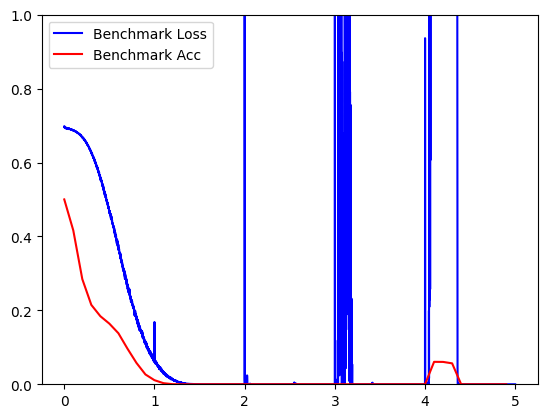

In [16]:
import matplotlib.pyplot as plt

mean_y_axis = None
mean_y_axis_short = None

for i in range(8):
    epoch_dict = standard_results[i]
    loss_arr = [epoch_dict["train_loss_arr"][i]["loss"] for i in range(len(epoch_dict["train_loss_arr"]))]
    acc_arr = [epoch_dict["train_loss_arr"][i]["test_acc"] for i in range(len(epoch_dict["train_loss_arr"]))]
    n = len(loss_arr)
    x_axis = []
    for epoch_idx, batch_losses in enumerate(loss_arr):
        x_axis.extend([epoch_idx + b_idx / len(batch_losses) for b_idx in range(len(batch_losses))])
    y_axis = []
    for j in range(n):
        y_axis.extend(loss_arr[j])
    
    x_axis_short = []
    y_axis_short = []
    for epoch_idx, batch_losses in enumerate(acc_arr):
        x_axis_short.extend([epoch_idx + sample_idx / len(batch_losses) for sample_idx in range(len(batch_losses))])
    for j in range(n):
        y_axis_short.extend(acc_arr[j])
    for j in range(len(y_axis_short)):
        y_axis_short[j] /= 1000
        y_axis_short[j] = 1-y_axis_short[j]

    if mean_y_axis is None:
        mean_y_axis = y_axis
    else:
        for j in range(len(mean_y_axis)):
            mean_y_axis[j] += y_axis[j]

    if mean_y_axis_short is None:
        mean_y_axis_short = y_axis_short
    else:
        for j in range(len(mean_y_axis_short)):
            mean_y_axis_short[j] += y_axis_short[j] 
    # plt.ylim(0,1)
    # plt.plot(x_axis, y_axis, color='blue', label='Benchmark Loss')
    # plt.plot(x_axis_short, y_axis_short, color='red', label='Benchmark Acc')
    # plt.legend()
    # plt.show()         

for j in range(len(mean_y_axis_short)):
    mean_y_axis_short[j] /= 8
for j in range(len(mean_y_axis)):
    mean_y_axis[j] /= 8

# plt.ylim(0,1)
# plt.plot(x_axis, mean_y_axis, color='blue', label='Benchmark Loss')
# plt.plot(x_axis_short, mean_y_axis_short, color='red', label='Benchmark Acc')
# plt.legend()
# plt.show()

In [18]:
seeds = [i for i in range(4)]
seeds_2 = [i+4 for i in range(4)]
hyperparams_list = [{
    "batch_size_d": 50,
    "BPTT_T_d": 20,
    "echo_step_d": 3,
    "n_epochs": 5,
    "optimizer_args": {"lr": 3e-4, "betas": (0.95, 0.95)}
}for i in range(4)]


new_results_1 = Parallel(n_jobs=4)(
    delayed(run_trial)(seed, False, **hparams)
    for seed, hparams in zip(seeds,  hyperparams_list)
)

new_results_2 = Parallel(n_jobs=4)(
    delayed(run_trial)(seed, False, **hparams)
    for seed, hparams in zip(seeds_2,  hyperparams_list)
)

new_results = new_results_1 + new_results_2

00 0  00 00
0 0 0

 0 0
0 / 1000
0 / 1000
0 / 1000
0 / 1000
1 / 1000
1 / 1000
1 / 1000
2 / 1000
1 / 1000
3 / 1000
2 / 1000
2 / 1000
2 / 1000
4 / 1000
3 / 1000
3 / 1000
3 / 1000
5 / 1000
4 / 1000
4 / 1000
4 / 1000
6 / 1000
5 / 1000
5 / 1000
5 / 1000
7 / 1000
8 / 1000
6 / 1000
6 / 1000
6 / 1000
9 / 1000
7 / 1000
7 / 1000
7 / 1000
10 / 1000
8 / 1000
8 / 1000
8 / 1000
11 / 1000
9 / 1000
9 / 1000
9 / 1000
12 / 1000
10 / 1000
10 / 1000
10 / 1000
13 / 1000
11 / 1000
14 / 1000
11 / 1000
11 / 1000
15 / 1000
12 / 1000
12 / 1000
12 / 1000
16 / 1000
13 / 1000
13 / 1000
13 / 1000
17 / 1000
14 / 1000
14 / 1000
14 / 1000
18 / 1000
15 / 1000
15 / 1000
19 / 1000
15 / 1000
16 / 1000
20 / 1000
16 / 1000
16 / 1000
21 / 1000
17 / 1000
17 / 1000
17 / 1000
22 / 1000
18 / 1000
18 / 1000
18 / 1000
23 / 1000
19 / 1000
19 / 1000
19 / 1000
24 / 1000
20 / 1000
25 / 1000
20 / 1000
20 / 1000
26 / 1000
21 / 1000
21 / 1000
21 / 1000
27 / 1000
22 / 1000
22 / 1000
22 / 1000
28 / 1000
23 / 1000
23 / 1000
23 / 1000
29 / 1

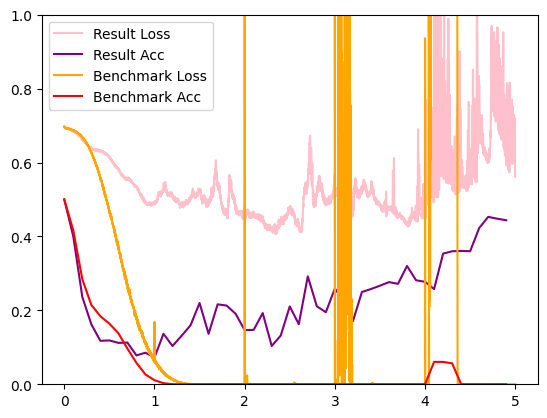

In [22]:
import matplotlib.pyplot as plt

mean_y_axis_new = None
mean_y_axis_short_new = None

for i in range(8):
    epoch_dict = new_results[i]
    loss_arr = [epoch_dict["train_loss_arr"][i]["loss"] for i in range(len(epoch_dict["train_loss_arr"]))]
    acc_arr = [epoch_dict["train_loss_arr"][i]["test_acc"] for i in range(len(epoch_dict["train_loss_arr"]))]
    n = len(loss_arr)
    x_axis = []
    for epoch_idx, batch_losses in enumerate(loss_arr):
        x_axis.extend([epoch_idx + b_idx / len(batch_losses) for b_idx in range(len(batch_losses))])
    y_axis = []
    for j in range(n):
        y_axis.extend(loss_arr[j])
    
    x_axis_short = []
    y_axis_short = []
    for epoch_idx, batch_losses in enumerate(acc_arr):
        x_axis_short.extend([epoch_idx + sample_idx / len(batch_losses) for sample_idx in range(len(batch_losses))])
    for j in range(n):
        y_axis_short.extend(acc_arr[j])
    for j in range(len(y_axis_short)):
        y_axis_short[j] /= 1000
        y_axis_short[j] = 1-y_axis_short[j]

    if mean_y_axis_new is None:
        mean_y_axis_new = y_axis
    else:
        for j in range(len(mean_y_axis_new)):
            mean_y_axis_new[j] += y_axis[j]

    if mean_y_axis_short_new is None:
        mean_y_axis_short_new = y_axis_short
    else:
        for j in range(len(mean_y_axis_short_new)):
            mean_y_axis_short_new[j] += y_axis_short[j]       

    # plt.ylim(0,1)
    # plt.plot(x_axis, y_axis, color='blue', label='Benchmark Loss')
    # plt.plot(x_axis_short, y_axis_short, color='red', label='Benchmark Acc')
    # plt.legend()
    # plt.show()    

for j in range(len(mean_y_axis_short_new)):
    mean_y_axis_short_new[j] /= 8
for j in range(len(mean_y_axis)):
    mean_y_axis_new[j] /= 8

plt.ylim(0,1)
plt.plot(x_axis, mean_y_axis_new, color='pink', label='Result Loss')
plt.plot(x_axis_short, mean_y_axis_short_new, color='purple', label='Result Acc')
plt.plot(x_axis, mean_y_axis, color='orange', label='Benchmark Loss')
plt.plot(x_axis_short, mean_y_axis_short, color='red', label='Benchmark Acc')
plt.legend()
plt.show()

## 4. Discussion
There are a few reasons why I think this optimizer doesn't work yet, and a few reasons why I still think this technique might still be fruitful

### 4.1 You don't want a $\Theta(lr)$ parameter update
Recall we are working with $g_{t, k} = \frac{dL_t}{dh_k}\frac{d^+h_k}{d\theta}$. Now our update for $\theta$ after receiving this gradient has a magnitude $\Theta(lr)$, due to Adam's mechanics. However, consider the case when $g_{t,k}$ is really small, then updating $\theta$ by a $\Theta(lr)$ sized update will only change $L_t$ by roughly $g_{t,k}*lr$. Maybe the "proper" optimization rule is to make $g_{t,k}*lr = \Theta(1)$. Now I don't have a quantitative reasoning for this, just the heuristic that I'd like different $\Delta$ updates to contribute equally to the improvement of the model.

### 4.2 The accuracy decreases very fast
This phenomenon surprises me, the error rate drops faster for the new optimization, but the loss hardly drops, and then after a while it climbs and climbs, maybe because I'm missing out on a standard regularizer (maybe weight decay?)

### 4.3 There is too much noise in the loss landscape by doing all these updates at once
In theory, Adam's SNR aspect should be tuning out noisy gradients, but maybe my beta's are too large or $\frac{1}{\sqrt{1 + x^2}}$ doesn't decrease fast enough. You can see this noise, especially in diffs 3, 4, 5, where the cosine similarity oscillates between -1 and 1, suggesting that it really doesn't know the right direction to go. These moderately sized updates might be confusing the loss landscapes of other optimizers, i.e. by making the update sizes moderate, we are accepting considerably more noisy gradients.

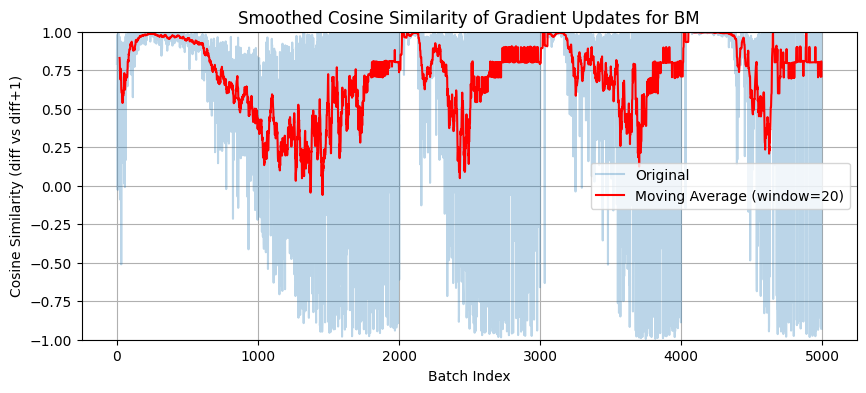

In [54]:
import torch
import matplotlib.pyplot as plt
import numpy as np

diff_1 = 4
diff_2 = 3
window_size = 20  # moving average window, adjust as needed

num_batches = len(standard_results[1]["train_loss_arr"][0]["grad"])
num_epochs = len(standard_results[0]["train_loss_arr"])
cos_sims = []

for epoch in range(num_epochs):
    for batch_idx in range(num_batches-1):
        # Can either have this like (batch_idx, diff_1) vs (batch_idx+1, diff_1)
        # Or can have it like (batch_idx, diff)

        grad_1_dict = standard_results[2]["train_loss_arr"][epoch]["grad"][batch_idx]
        grad_2_dict = standard_results[2]["train_loss_arr"][epoch]["grad"][batch_idx + 1]
        
        # if batch_idx == 950:
        #     print(grad_1_dict)

        # Flatten all parameter gradients into single vectors
        grad_1_vec = torch.cat([
            g['grad'].flatten() if g['grad'] is not None and name == "rnn_cell.weight_hh" else torch.zeros_like(g['param']).flatten()
            for name, g in grad_1_dict.items()
        ])
        grad_2_vec = torch.cat([
            g['grad'].flatten() if g['grad'] is not None and name == "rnn_cell.weight_hh" else torch.zeros_like(g['param']).flatten()
            for name, g in grad_2_dict.items()
        ])    
        # Cosine similarity
        cos_sim = torch.nn.functional.cosine_similarity(grad_1_vec, grad_2_vec, dim=0)
        cos_sims.append(cos_sim.item())

# Convert to numpy array for smoothing
cos_sims = np.array(cos_sims)

# Moving average
smoothed = np.convolve(cos_sims, np.ones(window_size)/window_size, mode='valid')

# Plot
plt.figure(figsize=(10,4))
plt.ylim(-1,1)
plt.plot(cos_sims, alpha=0.3, label='Original')
plt.plot(np.arange(window_size-1, num_epochs*(num_batches-1)), smoothed, color='red', label=f'Moving Average (window={window_size})')
plt.xlabel("Batch Index")
plt.ylabel("Cosine Similarity (diff vs diff+1)")
plt.title(f"Smoothed Cosine Similarity of Gradient Updates for BM")
plt.grid(True)
plt.legend()
plt.show()


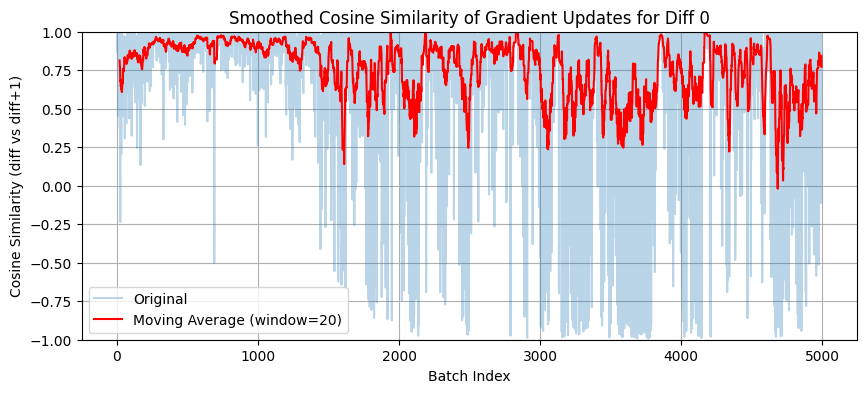

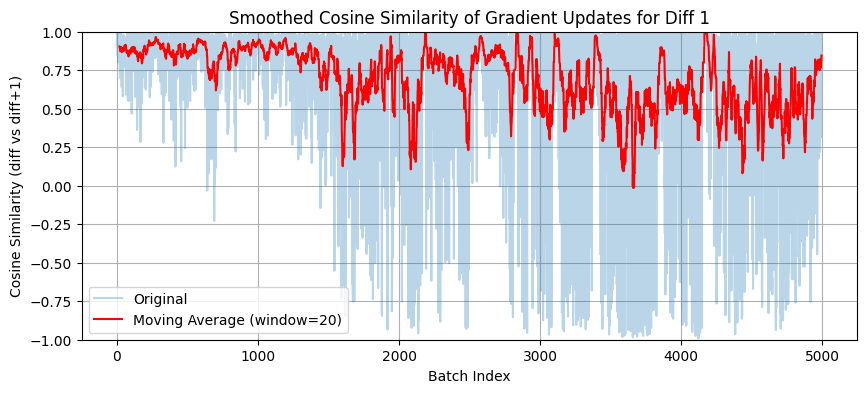

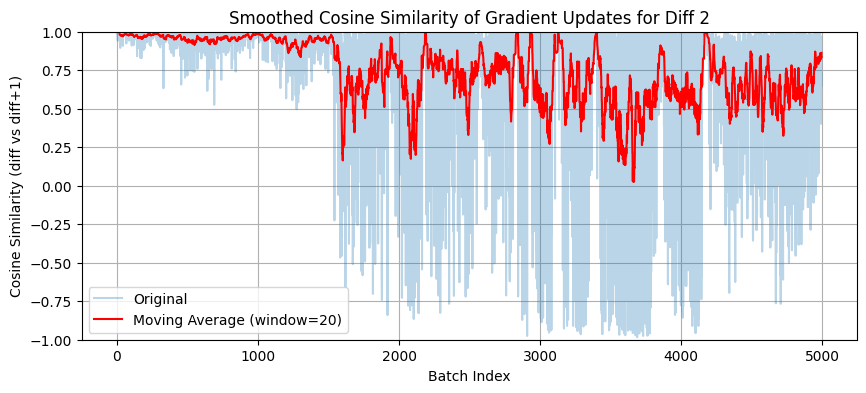

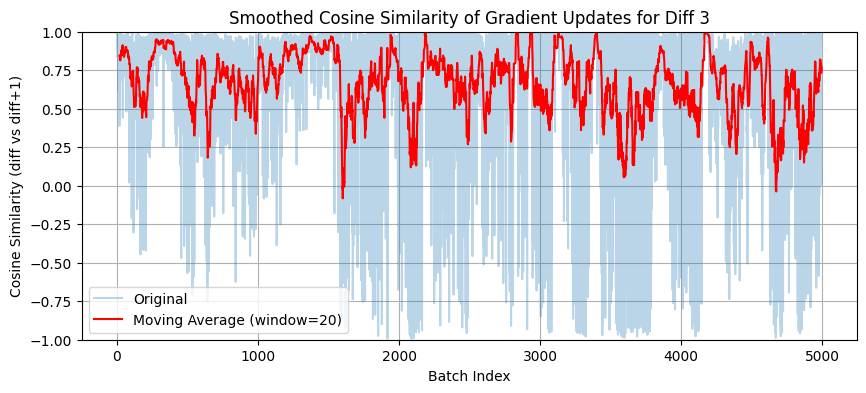

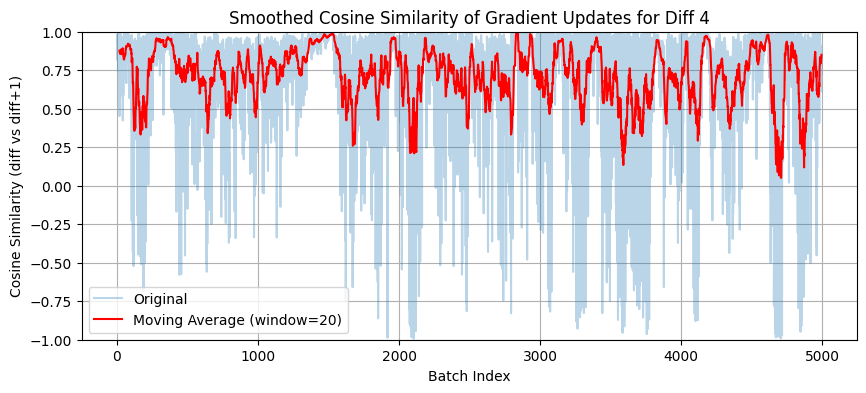

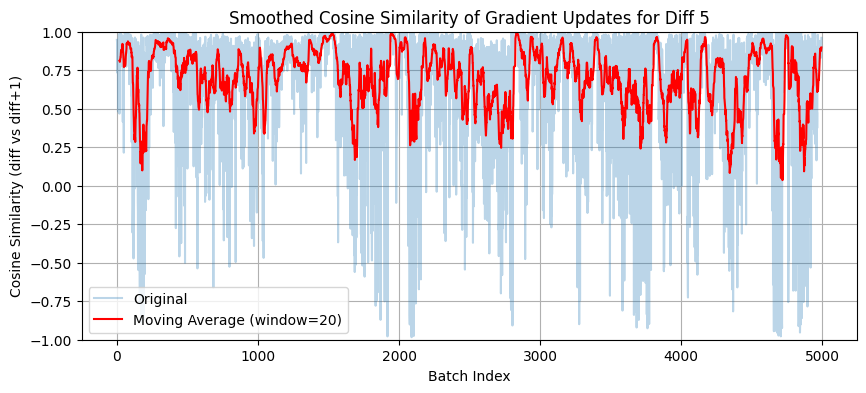

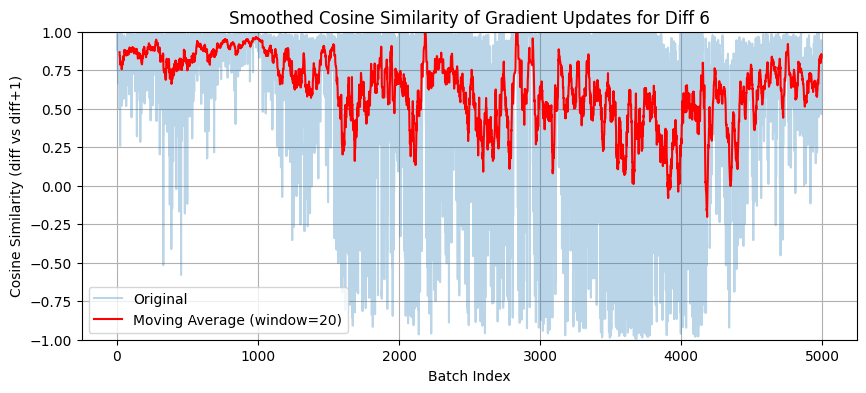

In [55]:
import torch
import matplotlib.pyplot as plt
import numpy as np

sample = 0 # 0 through 7

for diff_1 in range(7):
    window_size = 20  # moving average window, adjust as needed

    num_batches = len(new_results[1]["train_loss_arr"][0]["grad"])
    num_epochs = len(new_results[0]["train_loss_arr"])
    cos_sims = []

    for epoch in range(num_epochs):
        for batch_idx in range(num_batches-1):
            # Can either have this like (batch_idx, diff_1) vs (batch_idx+1, diff_1)
            # Or can have it like (batch_idx, diff)

            grad_1_dict = new_results[7]["train_loss_arr"][epoch]["grad"][batch_idx][diff_1]
            grad_2_dict = new_results[7]["train_loss_arr"][epoch]["grad"][batch_idx + 1][diff_1]
            
            # if batch_idx == 950:
            #     print(grad_1_dict)

            # Flatten all parameter gradients into single vectors
            grad_1_vec = torch.cat([
                g['grad'].flatten() if g['grad'] is not None and name == "rnn_cell.weight_hh" else torch.zeros_like(g['param']).flatten()
                for name, g in grad_1_dict.items()
            ])
            grad_2_vec = torch.cat([
                g['grad'].flatten() if g['grad'] is not None and name == "rnn_cell.weight_hh" else torch.zeros_like(g['param']).flatten()
                for name, g in grad_2_dict.items()
            ])    
            # Cosine similarity
            cos_sim = torch.nn.functional.cosine_similarity(grad_1_vec, grad_2_vec, dim=0)
            cos_sims.append(cos_sim.item())

    # Convert to numpy array for smoothing
    cos_sims = np.array(cos_sims)

    # Moving average
    smoothed = np.convolve(cos_sims, np.ones(window_size)/window_size, mode='valid')

    # Plot
    plt.figure(figsize=(10,4))
    plt.ylim(-1,1)
    plt.plot(cos_sims, alpha=0.3, label='Original')
    plt.plot(np.arange(window_size-1, num_epochs*(num_batches-1)), smoothed, color='red', label=f'Moving Average (window={window_size})')
    plt.xlabel("Batch Index")
    plt.ylabel("Cosine Similarity (diff vs diff+1)")
    plt.title(f"Smoothed Cosine Similarity of Gradient Updates for Diff {diff_1}")
    plt.grid(True)
    plt.legend()
    plt.show()


### Appendix
I had to include gradient clipping because otherwise gradients would explode wildly. This still doesn't seem to have fixed the issue

1000


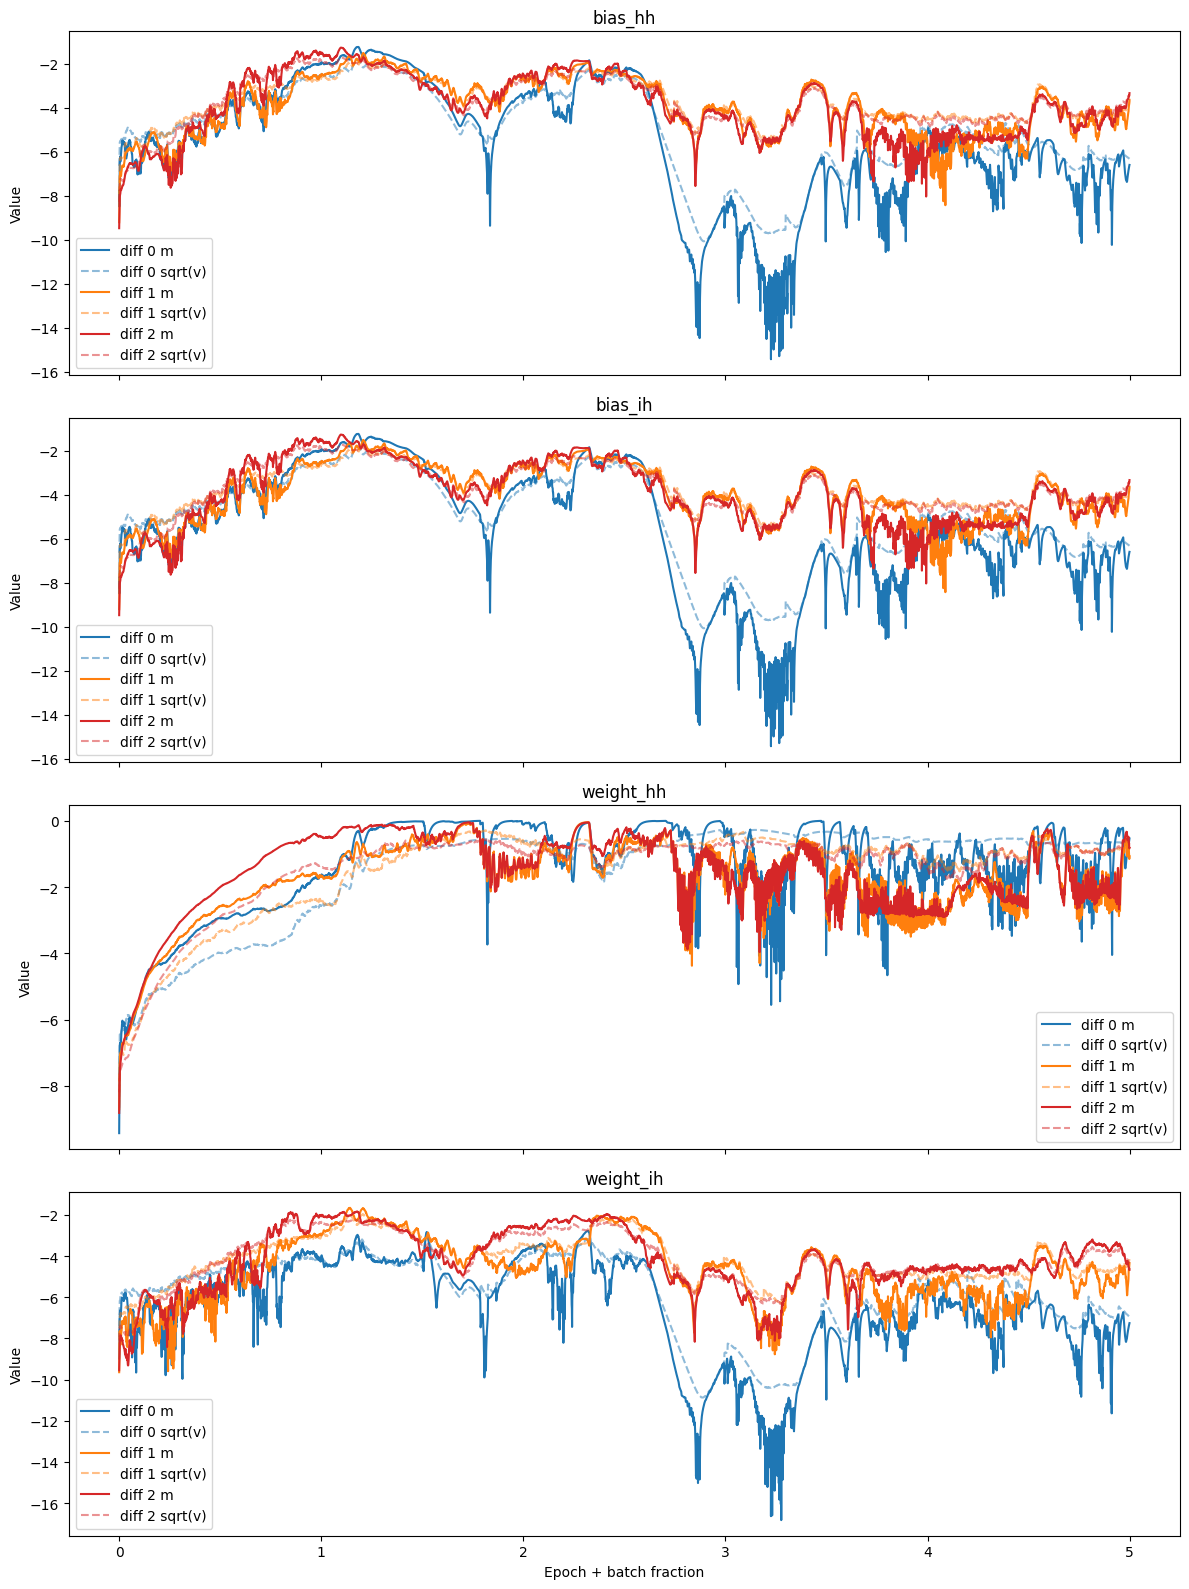

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Example: data shape [epochs][batches][diffs][{param_name: (m, v)}]
data = new_results[2]["train_loss_arr"]

epochs = 5
batches_per_epoch = len(data[0]["optim"])
print(batches_per_epoch)
diffs = len(data[0]["optim"][0])
param_names = list(data[0]["optim"][0][0].keys())  # assume all dicts have same keys
param_names = sorted(set(param_names) - set(["diff"]))

colors = plt.cm.tab10(np.linspace(0, 1, diffs))

fig, axes = plt.subplots(len(param_names), 1, figsize=(12, 4 * len(param_names)), sharex=True)

if len(param_names) == 1:
    axes = [axes]  # make iterable

for ax, param in zip(axes, param_names):
    if param == 'diff':
        continue
    for diff_idx in range(diffs):
        if diff_idx > 2:
            continue
        x_vals = []
        m_vals = []
        sqrt_v_vals = []
        for epoch_idx in range(epochs):
            for batch_idx in range(batches_per_epoch):
                fraction = epoch_idx + batch_idx / batches_per_epoch
                x_vals.append(fraction)
                m, v = data[epoch_idx]["optim"][batch_idx][diff_idx][param]['norm_exp_avg'], data[epoch_idx]["optim"][batch_idx][diff_idx][param]['norm_exp_avg_sq']
                
                # Lets do Log instead
                m_vals.append(np.log(m))
                sqrt_v_vals.append(np.log(np.sqrt(v)))
        # plot m (dark)
        ax.plot(x_vals, m_vals, color=colors[diff_idx], label=f'diff {diff_idx} m')
        # plot sqrt(v) (light)
        ax.plot(x_vals, sqrt_v_vals, color=colors[diff_idx], linestyle='--', alpha=0.5, label=f'diff {diff_idx} sqrt(v)')

    ax.set_title(param)
    ax.set_ylabel('Value')
    ax.legend()

axes[-1].set_xlabel('Epoch + batch fraction')

# plt.set_title("Tracking Inner State of Adam Optimizer")
plt.tight_layout()
plt.show()
